In [1]:
# Define the gpu  on the gpu machine
%env CUDA_DEVICE_ORDER=PCI_BUS_ID
%env CUDA_VISIBLE_DEVICES=7

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from evaluation import testing
import pandas as pd
from copy import deepcopy
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


env: CUDA_DEVICE_ORDER=PCI_BUS_ID
env: CUDA_VISIBLE_DEVICES=7


## Prepare the final evaluated corpus

In [3]:
# Import the annotated corpus

ann_df = pd.read_json("/cache/tajak/macocu-mt/datasets/manually-evaluated/MaCoCu-mt-genre-sample-evaluated.jsonl", lines=True)
print(ann_df.shape)
display(ann_df.head(2))

(80, 6)


,text_id,y_pred,text,translation,metadata,y_true
0,macocu.mt.402244,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},News
1,macocu.mt.377203,Prose/Lyrical,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},Opinion/Argumentation


In [3]:
# Discard unnecessary columns
ann_df = ann_df[["text","metadata","label"]]

# Rename columns
ann_df.columns = [["translation","metadata","y_true"]]

# Extract the text ids
text_ids = []

for i in np.array(ann_df.metadata):
	text_ids.append(i[0]["text_id"])

# Add the ids to the ann_df

ann_df["text_id"] = text_ids

ann_df.head(3)

,translation,metadata,y_true,text_id
0,"Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},[News],macocu.mt.402244
1,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},[Opinion/Argumentation],macocu.mt.377203
2,Chrysler: Luxury brand or not?\n\nBrand moves ...,{'text_id': 'macocu.mt.109995'},[Opinion/Argumentation],macocu.mt.109995


In [4]:
# Import the genre sample with gold labels
sample = pd.read_json("/cache/tajak/macocu-mt/datasets/samples/MaCoCu-mt-genre-sample.json", lines=True)

# Rename the document_id column to text_id
sample = sample.rename(columns={"document_id":"text_id"})

sample.head()

,text_id,text,genre,translation
0,macocu.mt.402244,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...",News,"Angelo Chetcuti, will be replacing Bjorn Vassa..."
1,macocu.mt.377203,Poltergeist jirreferi għal fenomeni oħra tal-m...,Prose/Lyrical,"Poltergeist refers to other woman's phenomena,..."
2,macocu.mt.109995,Chrysler: Brand ta 'lussu jew le? \n\nBrand ji...,Forum,Chrysler: Luxury brand or not?\n\nBrand moves ...
3,macocu.mt.243402,Kif tkellem lit-tfal dwar id-diżabbiltajiet \n...,Forum,How to talk to children about disabilities\n\n...
4,macocu.mt.213859,Kif tneħħi hangover sewwa u bla perikolu \n\nH...,Forum,How to remove a proper and safe hangover\n\nHa...


In [5]:
# Correct some problems with multiple columns which prevent merging the dataframes
sample.columns = sample.columns.map(''.join)
sample = sample.reset_index()

ann_df.columns = ann_df.columns.map(''.join)
ann_df = ann_df.reset_index()

# Merge based on translated text

df_sq = pd.merge(sample, ann_df, on="text_id", how="outer")

df_sq.head()

,index_x,text_id,text,genre,translation_x,index_y,translation_y,metadata,y_true
0,0,macocu.mt.402244,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...",News,"Angelo Chetcuti, will be replacing Bjorn Vassa...",0,"Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},[News]
1,1,macocu.mt.377203,Poltergeist jirreferi għal fenomeni oħra tal-m...,Prose/Lyrical,"Poltergeist refers to other woman's phenomena,...",1,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},[Opinion/Argumentation]
2,2,macocu.mt.109995,Chrysler: Brand ta 'lussu jew le? \n\nBrand ji...,Forum,Chrysler: Luxury brand or not?\n\nBrand moves ...,2,Chrysler: Luxury brand or not?\n\nBrand moves ...,{'text_id': 'macocu.mt.109995'},[Opinion/Argumentation]
3,3,macocu.mt.243402,Kif tkellem lit-tfal dwar id-diżabbiltajiet \n...,Forum,How to talk to children about disabilities\n\n...,3,How to talk to children about disabilities\n\n...,{'text_id': 'macocu.mt.243402'},[Instruction]
4,4,macocu.mt.213859,Kif tneħħi hangover sewwa u bla perikolu \n\nH...,Forum,How to remove a proper and safe hangover\n\nHa...,4,How to remove a proper and safe hangover\n\nHa...,{'text_id': 'macocu.mt.213859'},[Instruction]


In [6]:
# Keep only relevant columns
df_sq = df_sq[['text_id', 'genre', 'text', 'translation_y', 'metadata', 'y_true']]

# Rename the columns
df_sq = df_sq.rename(columns={"genre":"y_pred", "translation_y":"translation"})

# Change y_true labels
df_sq["y_true"] = df_sq["y_true"].apply(lambda x:x[0])


df_sq.head(2)

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.mt.402244,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},News
1,macocu.mt.377203,Prose/Lyrical,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},Opinion/Argumentation


In [8]:
# Save the corpus
df_sq.to_json("/cache/tajak/macocu-mt/datasets/manually-evaluated/MaCoCu-mt-genre-sample-evaluated.jsonl", orient="records", lines=True)

## Analyze the results

In [2]:
# Import the prepared annotated corpus with all the information
df_sq =pd.read_json("/cache/tajak/macocu-mt/datasets/manually-evaluated/MaCoCu-mt-genre-sample-evaluated.jsonl", orient="records", lines=True)
df_sq.head()

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.mt.402244,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},News
1,macocu.mt.377203,Prose/Lyrical,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},Opinion/Argumentation
2,macocu.mt.109995,Forum,Chrysler: Brand ta 'lussu jew le? \n\nBrand ji...,Chrysler: Luxury brand or not?\n\nBrand moves ...,{'text_id': 'macocu.mt.109995'},Opinion/Argumentation
3,macocu.mt.243402,Forum,Kif tkellem lit-tfal dwar id-diżabbiltajiet \n...,How to talk to children about disabilities\n\n...,{'text_id': 'macocu.mt.243402'},Instruction
4,macocu.mt.213859,Forum,Kif tneħħi hangover sewwa u bla perikolu \n\nH...,How to remove a proper and safe hangover\n\nHa...,{'text_id': 'macocu.mt.213859'},Instruction


In [5]:
# Analyze number of problematic texts
print(df_sq["y_true"].value_counts().to_markdown())
print("\n")
print(df_sq["y_true"].value_counts(normalize="True").to_markdown())
print("\n--------------------------------------\n\n")

| y_true                  |   count |
|:------------------------|--------:|
| Instruction             |      18 |
| News                    |      15 |
| Information/Explanation |      13 |
| Promotion               |      12 |
| Legal                   |      10 |
| Opinion/Argumentation   |       8 |
| Multiple texts          |       2 |
| Forum                   |       1 |
| Prose/Lyrical           |       1 |


| y_true                  |   proportion |
|:------------------------|-------------:|
| Instruction             |       0.225  |
| News                    |       0.1875 |
| Information/Explanation |       0.1625 |
| Promotion               |       0.15   |
| Legal                   |       0.125  |
| Opinion/Argumentation   |       0.1    |
| Multiple texts          |       0.025  |
| Forum                   |       0.0125 |
| Prose/Lyrical           |       0.0125 |

--------------------------------------




In [3]:
# Filter out "Other" instances and "Problematic" instances so that we will do analysis on clear examples only
df_test_clean = df_sq[df_sq["y_pred"] != "Other"]
df_test_clean = df_test_clean[df_test_clean["y_true"] != "Multiple texts"]
df_test_clean = df_test_clean[df_test_clean["y_true"] != "Incomprehensible"]
df_test_clean = df_test_clean[df_test_clean["y_true"] != "Other"]

df_test_clean.describe(include="all")

,text_id,y_pred,text,translation,metadata,y_true
count,78,78,78,78,78,78
unique,78,8,78,78,78,8
top,macocu.mt.402244,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},Instruction
freq,1,10,1,1,1,18


In [4]:
# Analyze y_pred labels in cleaned corpora
print(df_test_clean["y_pred"].value_counts().to_markdown())
print("\n--------------------------------------\n\n")
print(df_test_clean["y_pred"].value_counts(normalize="True").to_markdown())


| y_pred                  |   count |
|:------------------------|--------:|
| News                    |      10 |
| Forum                   |      10 |
| Information/Explanation |      10 |
| Opinion/Argumentation   |      10 |
| Legal                   |      10 |
| Promotion               |      10 |
| Prose/Lyrical           |       9 |
| Instruction             |       9 |

--------------------------------------


| y_pred                  |   proportion |
|:------------------------|-------------:|
| News                    |     0.128205 |
| Forum                   |     0.128205 |
| Information/Explanation |     0.128205 |
| Opinion/Argumentation   |     0.128205 |
| Legal                   |     0.128205 |
| Promotion               |     0.128205 |
| Prose/Lyrical           |     0.115385 |
| Instruction             |     0.115385 |


Macro f1: 0.555, Micro f1: 0.615
Accuracy: 0.615


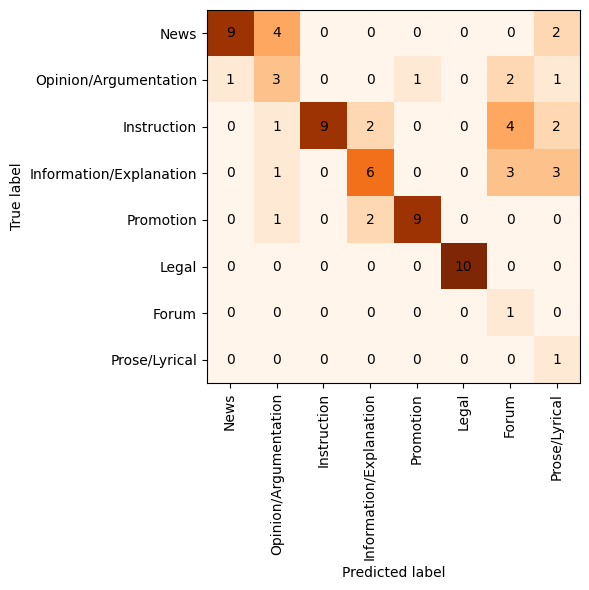

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Forum                   |    0.1      | 1        |   0.181818 |  1        |
| Information/Explanation |    0.6      | 0.461538 |   0.521739 | 13        |
| Instruction             |    1        | 0.5      |   0.666667 | 18        |
| Legal                   |    1        | 1        |   1        | 10        |
| News                    |    0.9      | 0.6      |   0.72     | 15        |
| Opinion/Argumentation   |    0.3      | 0.375    |   0.333333 |  8        |
| Promotion               |    0.9      | 0.75     |   0.818182 | 12        |
| Prose/Lyrical           |    0.111111 | 1        |   0.2      |  1        |
| accuracy                |    0.615385 | 0.615385 |   0.615385 |  0.615385 |
| macro avg               |    0.613889 | 0.710817 |   0.555217 | 78        |
| weighted avg            |    0.803989 | 0.615385 |   0.672427 

<Figure size 640x480 with 0 Axes>

In [5]:
y_pred = df_test_clean["y_pred"].to_list()
y_true = df_test_clean["y_true"].to_list()
labels = list(df_test_clean["y_true"].unique())

results = testing(y_true, y_pred, labels)

# Add Dummy results

In [6]:
from sklearn.dummy import DummyClassifier


In [20]:
# Import the dataset on which the X-GENRE classifier was trained
from datasets import load_dataset

train = load_dataset("TajaKuzman/X-GENRE-multilingual-text-genre-dataset", "train")

train_df = pd.DataFrame(train["train"])

train_df.head()

,text,labels,dataset,language
0,"Seeking All Things Brilliant ""I want people to...",Other,CORE,English
1,Meet Orchid du Bois I first met Hayley Mowday ...,Other,CORE,English
2,Abstract Objective: Reporting bias due to soci...,Information/Explanation,CORE,English
3,In 2009 the song was the focus of a successful...,Information/Explanation,CORE,English
4,QuotW This was the week when neither rumours o...,News,CORE,English


In [21]:
df_test_clean.head()

,text_id,y_pred,text,translation,metadata,y_true
0,macocu.mt.402244,News,"Angelo Chetcuti, se jkun qed jieħu post Bjorn ...","Angelo Chetcuti, will be replacing Bjorn Vassa...",{'text_id': 'macocu.mt.402244'},News
1,macocu.mt.377203,Prose/Lyrical,Poltergeist jirreferi għal fenomeni oħra tal-m...,"Poltergeist refers to other woman's phenomena,...",{'text_id': 'macocu.mt.377203'},Opinion/Argumentation
2,macocu.mt.109995,Forum,Chrysler: Brand ta 'lussu jew le? \n\nBrand ji...,Chrysler: Luxury brand or not?\n\nBrand moves ...,{'text_id': 'macocu.mt.109995'},Opinion/Argumentation
3,macocu.mt.243402,Forum,Kif tkellem lit-tfal dwar id-diżabbiltajiet \n...,How to talk to children about disabilities\n\n...,{'text_id': 'macocu.mt.243402'},Instruction
4,macocu.mt.213859,Forum,Kif tneħħi hangover sewwa u bla perikolu \n\nH...,How to remove a proper and safe hangover\n\nHa...,{'text_id': 'macocu.mt.213859'},Instruction


In [24]:
# Create X_train and Y_train parts, used for sci kit learning
# We need to split each split (test and train) into an object with just texts and object with just labels. Test df is df_test_clean
X_train = list(train_df.text)
Y_train = list(train_df.labels)

X_test = list(df_test_clean.text)
Y_test = list(df_test_clean["y_pred"])

# See their sizes
len(X_train), len(Y_train), len(X_test), len(Y_test)

(1772, 1772, 78, 78)

## Most-frequent dummy

Macro f1: 0.0403, Micro f1: 0.192
Accuracy: 0.192


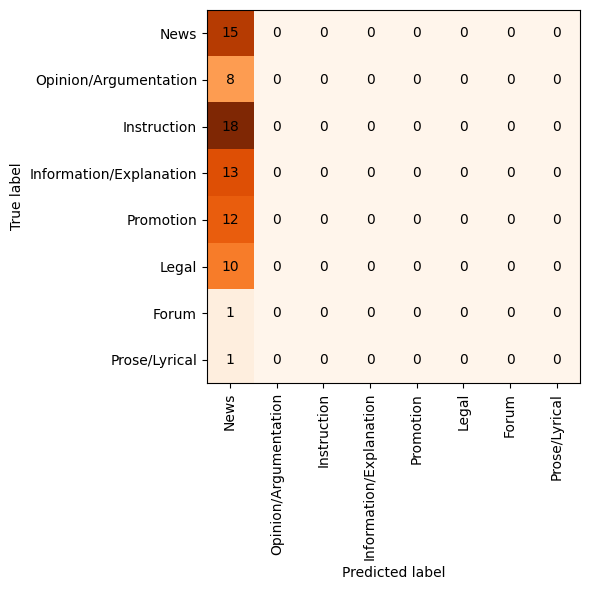

|                         |   precision |   recall |   f1-score |   support |
|:------------------------|------------:|---------:|-----------:|----------:|
| Forum                   |   0         | 0        |  0         |  1        |
| Information/Explanation |   0         | 0        |  0         | 13        |
| Instruction             |   0         | 0        |  0         | 18        |
| Legal                   |   0         | 0        |  0         | 10        |
| News                    |   0.192308  | 1        |  0.322581  | 15        |
| Opinion/Argumentation   |   0         | 0        |  0         |  8        |
| Promotion               |   0         | 0        |  0         | 12        |
| Prose/Lyrical           |   0         | 0        |  0         |  1        |
| accuracy                |   0.192308  | 0.192308 |  0.192308  |  0.192308 |
| macro avg               |   0.0240385 | 0.125    |  0.0403226 | 78        |
| weighted avg            |   0.0369822 | 0.192308 |  0.0620347 

/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` pa

<Figure size 640x480 with 0 Axes>

In [29]:
# Use the Dummy Classifier, with the strategy "most_frequent"
dummy_mf = DummyClassifier(strategy="most_frequent")

# Train the model
dummy_mf.fit(X_train, Y_train)

#Get the predictions
y_pred_mf = dummy_mf.predict(X_test)

# Evaluate the predictions
y_pred = list(y_pred_mf)
y_true = df_test_clean["y_true"].to_list()
labels = list(df_test_clean["y_true"].unique())

results = testing(y_true, y_pred, labels)

## Stratified dummy

Macro f1: 0.105, Micro f1: 0.131
Accuracy: 0.128


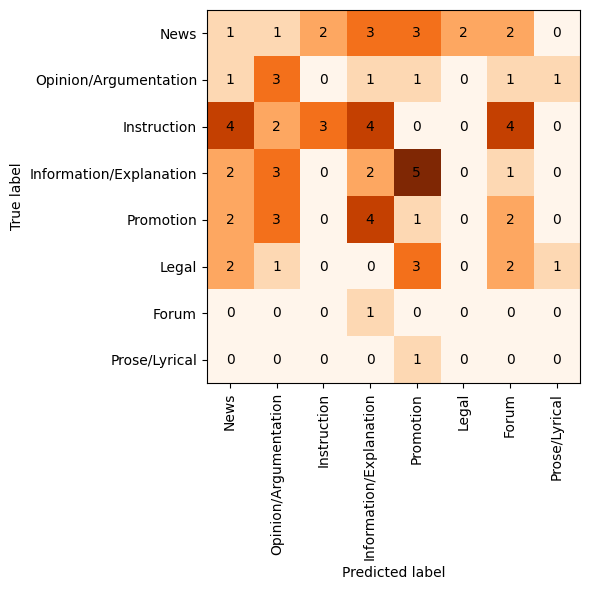

|                         |   precision |    recall |   f1-score |   support |
|:------------------------|------------:|----------:|-----------:|----------:|
| Forum                   |   0         | 0         |  0         |  1        |
| Information/Explanation |   0.133333  | 0.153846  |  0.142857  | 13        |
| Instruction             |   0.6       | 0.166667  |  0.26087   | 18        |
| Legal                   |   0         | 0         |  0         | 10        |
| News                    |   0.0833333 | 0.0666667 |  0.0740741 | 15        |
| Opinion/Argumentation   |   0.230769  | 0.375     |  0.285714  |  8        |
| Other                   |   0         | 0         |  0         |  0        |
| Promotion               |   0.0714286 | 0.0833333 |  0.0769231 | 12        |
| Prose/Lyrical           |   0         | 0         |  0         |  1        |
| accuracy                |   0.128205  | 0.128205  |  0.128205  |  0.128205 |
| macro avg               |   0.124318  | 0.0939459 

/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/tajak/Crosslingual-Genre-Bias-Analysis/crosslingual_venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this 

<Figure size 640x480 with 0 Axes>

In [30]:
# Use the Dummy Classifier, with the strategy "most_frequent"
dummy_s = DummyClassifier(strategy="stratified")

# Train the model
dummy_s.fit(X_train, Y_train)

#Get the predictions
y_pred_s = dummy_s.predict(X_test)

# Evaluate the predictions
y_pred = list(y_pred_s)
y_true = df_test_clean["y_true"].to_list()
labels = list(df_test_clean["y_true"].unique())

results = testing(y_true, y_pred, labels)